## 1. Постановка задачи

Представьте, что вы заказываете такси из одной точки Нью-Йорка в другую, причём необязательно, что конечная точка должна находиться в пределах города. Сколько вы должны будете заплатить за поездку?

Известно, что стоимость такси в США рассчитывается на основе фиксированной ставки и тарифной стоимости, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь, время поездки зависит от множества факторов, таких как направление поездки, время суток, погодные условия и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать её стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных



## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Импорт необходимых модулей

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
taxi_data = pd.read_csv("/content/drive/MyDrive/Project5_train_data.zip")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
total_trips = taxi_data.shape[0]
print(f'Всего было {total_trips} поездок.')

Всего было 1458644 поездок.


**Интерпретация столбцов в Датафрейме**:

* id: Идентификатор поездки (строка).
* vendor_id: Идентификатор поставщика услуги (целое число).
* pickup_datetime: Дата и время начала поездки (строка).
* dropoff_datetime: Дата и время окончания поездки (строка).
* passenger_count: Количество пассажиров (целое число).
* pickup_longitude: Долгота места начала поездки (число с плавающей запятой).
* pickup_latitude: Широта места начала поездки (число с плавающей запятой).
* dropoff_longitude: Долгота места окончания поездки (число с плавающей запятой).
* dropoff_latitude: Широта места окончания поездки (число с плавающей запятой).
* store_and_fwd_flag: Флаг, указывающий, был ли маршрут сохранен и переслан позже (строка).
* trip_duration: Продолжительность поездки в секундах (целое число).



Разделим признаки по типовым характеристикам

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [ ]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
timedelta = taxi_data['pickup_datetime'].max() - taxi_data['pickup_datetime'].min()
print(f'Данные взяты в промежутке от {taxi_data.pickup_datetime.min()} до {taxi_data.pickup_datetime.max()} в период {timedelta}')

Данные взяты в промежутке от 2016-01-01 00:00:17 до 2016-06-30 23:59:39 в период 181 days 23:59:22


### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [ ]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [ ]:
print(f'уникальных таксопарков присутствует {taxi_data.vendor_id.nunique()}')
print(f'максимальное количество пассажиров {taxi_data.passenger_count.max()}')
print(f'средняя длительность поездки {taxi_data.trip_duration.mean()} и медианная длительность поездки {taxi_data.trip_duration.median()}')
print(f'максимальное время поездкив {taxi_data.trip_duration.max()}')
print(f'минимальное время поездкив {taxi_data.trip_duration.min()}')

уникальных таксопарков присутствует 2
максимальное количество пассажиров 9
средняя длительность поездки 959.4922729603659 и медианная длительность поездки 662.0
максимальное время поездкив 3526282
минимальное время поездкив 1


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [ ]:
taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.date
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
taxi_data['day_of_week'] = taxi_data['pickup_datetime'].dt.day_of_week

In [ ]:
taxi_data['day_of_week'].value_counts()

day_of_week
4    223533
5    220868
3    218574
2    210136
1    202749
6    195366
0    187418
Name: count, dtype: int64

In [ ]:
round(taxi_data.shape[0]/taxi_data['pickup_date'].nunique())

8015

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [ ]:
holiday_data = pd.read_csv('/content/drive/MyDrive/holiday_data.zip', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%Y-%m-%d')
holiday_data['date'] = holiday_data['date'].dt.date

In [ ]:
taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(lambda x: 1 if x in holiday_data['date'].values else 0)

In [ ]:
taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()

585.0

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
osrm_data = pd.read_csv('/content/drive/MyDrive/osrm_data_train.zip')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [ ]:
#Оставим в выгруженной таблице данные только о total_distance, total_travel_time и number_of_steps.
osrm = osrm_data[['total_distance', 'total_travel_time', 'number_of_steps', 'id']]

#Объединим наши таблицы по признаку id методом left
taxi_data = taxi_data.merge(osrm, on='id', how='left')

#Найдем разницу (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM
print(f'Разница составила {taxi_data["trip_duration"].median() - taxi_data["total_travel_time"].median()}')

#Посчитаем количество пропусков после объединения таблиц
print(f'Всего пропусков {taxi_data.isnull().sum().sum()}')

Разница составила 372.5
Всего пропусков 3


In [ ]:
#Посмортим на количество пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
day_of_week           0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [ ]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps'],
      dtype='object')

In [ ]:
def add_geographical_features(x):
  lat1 = x['pickup_latitude']
  lng1 = x['pickup_longitude']
  lat2 = x['dropoff_latitude']
  lng2 = x['dropoff_longitude']
  x['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
  x['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
  return x

In [ ]:
import time
from tqdm import tqdm
tqdm.pandas()
taxi_data = taxi_data.progress_apply(add_geographical_features, axis=1)

100%|██████████| 1458644/1458644 [35:48<00:00, 678.99it/s]


In [ ]:
taxi_data['haversine_distance'].median()


2.0937171329263693

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(x, model):
    x['geo_cluster'] = model.predict(x[['pickup_latitude', 'pickup_longitude',
                                                  'dropoff_latitude','dropoff_longitude']].values)
    return x

taxi_data = add_cluster_features(taxi_data, kmeans)

# Сколько поездок содержится в наименьшем по размеру географическом кластере?
print(taxi_data['geo_cluster'].value_counts().min())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [ ]:
print(taxi_data.columns)


Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip',
       'events'],
      dtype='object')


In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/SF/weather_data.zip')

weather_columns = ['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']

#Объединим нужные нам 5 признаков по признакам даты и времени, взяв только те даты, что есть в данных о поездках.
taxi_data = taxi_data.merge(weather_data[weather_columns], left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')

print(f'Поездок было совершено в снежную погоду ровно {taxi_data.events.value_counts()["Snow"]}')

print(f'Доля (в процентах) в общем количестве наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями равна {np.round(taxi_data.isnull().sum().max() / taxi_data.shape[0] * 100, 2)}')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SF/weather_data.zip'

In [ ]:
print(f'Всего признаков {taxi_data.shape[1]}, а должно быть 26')

#при объединении добавились 7 признаков вместо 5, удалим лишнее
taxi_data = taxi_data.drop(['date', 'hour'], axis=1)

print(f'В итоге признаков осталось {taxi_data.shape[1]}')

Всего признаков 35, а должно быть 26


KeyError: "['date', 'hour'] not found in axis"

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [ ]:
def clear_null_data(x):
    weather_col = ['temperature', 'visibility', 'wind speed', 'precip']

    x['events'] = x['events'].fillna('None')

    for col in weather_col:
        x[col] = x[col].fillna(x.groupby('pickup_date')[col].transform('median'))

    osrm_col = ['total_distance', 'total_travel_time', 'number_of_steps']

    for col in osrm_col:
        x[col] = x[col].fillna(x[col].median())

    return x

In [ ]:
taxi_data = clear_null_data(taxi_data)
print(f'медиана в столбце temperature после заполнения пропусков равна {taxi_data["temperature"].median()}')

KeyError: 'events'

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


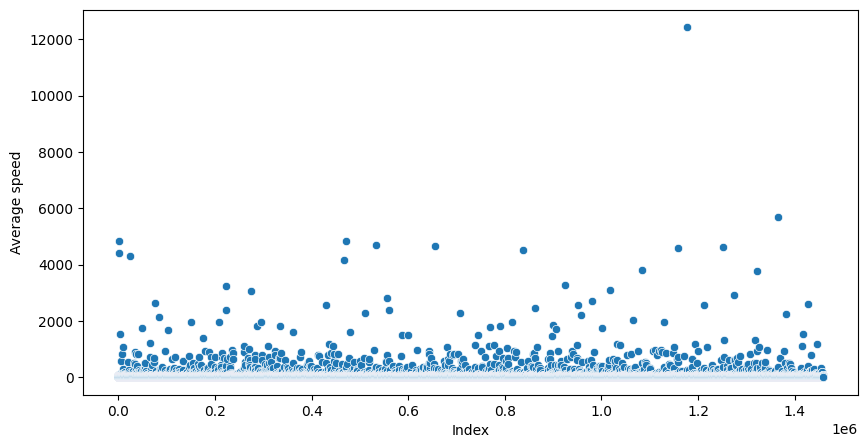

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.




### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [ ]:
out_time = taxi_data[taxi_data['trip_duration'] > 24*60*60].count().mean()
print(f'выбросов по признаку длительности поездки удалось найти ровно {out_time}')

taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

out_speed = taxi_data[taxi_data['avg_speed'] > 300].count().mean()
print(f'выбросов по признаку скорости удалось найти ровно {out_speed}')

#создадим список индексов с данными для удаления
drop_indexes = list(taxi_data[taxi_data['trip_duration'] > 24*60*60].index) + list(taxi_data[taxi_data['avg_speed'] > 300].index)

taxi_data = taxi_data.drop(drop_indexes)

выбросов по признаку длительности поездки удалось найти ровно 2.4
выбросов по признаку скорости удалось найти ровно 248.11111111111111


### Save point_1


In [ ]:
#Создадим точку восстановления, чтобы можно было вернуться в любой момент
taxi_data.to_csv('/content/drive/MyDrive/temp_df.csv')

taxi_data = pd.read_csv('/content/drive/MyDrive/temp_df.csv', index_col=0)
#Проверим, что датасет тот самый
print(taxi_data.shape)
taxi_data.head()

(1458644, 11)


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_log
id,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

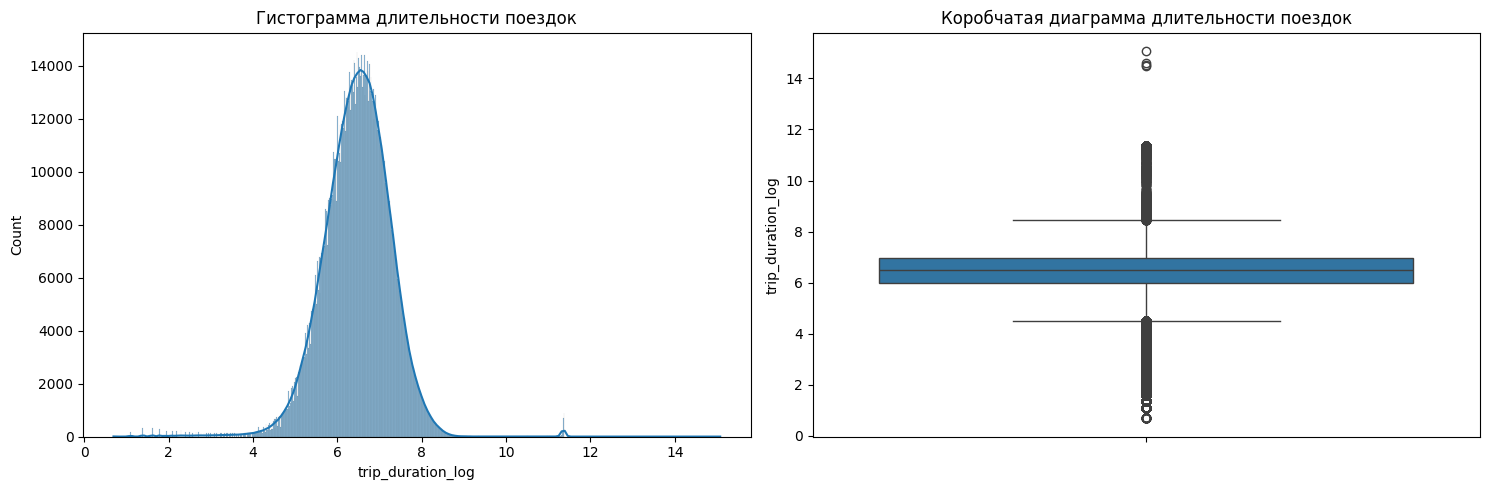

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Гистограмма длительности поездок')
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    ax=ax[0],
    kde=True
    )

ax[1].set_title('Коробчатая диаграмма длительности поездок')
sns.boxplot(
    ax=ax[1],
    data=taxi_data,
    y='trip_duration_log'
    )

fig.tight_layout()

In [ ]:
H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p_value = stats.normaltest(taxi_data['trip_duration_log'])

print(f'{H1}, так как p-value={p_value} < alpha/2 = {alpha/2}')

Данные не распределены нормально (мы отвергаем H0), так как p-value=0.0 < alpha/2 = 0.025


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

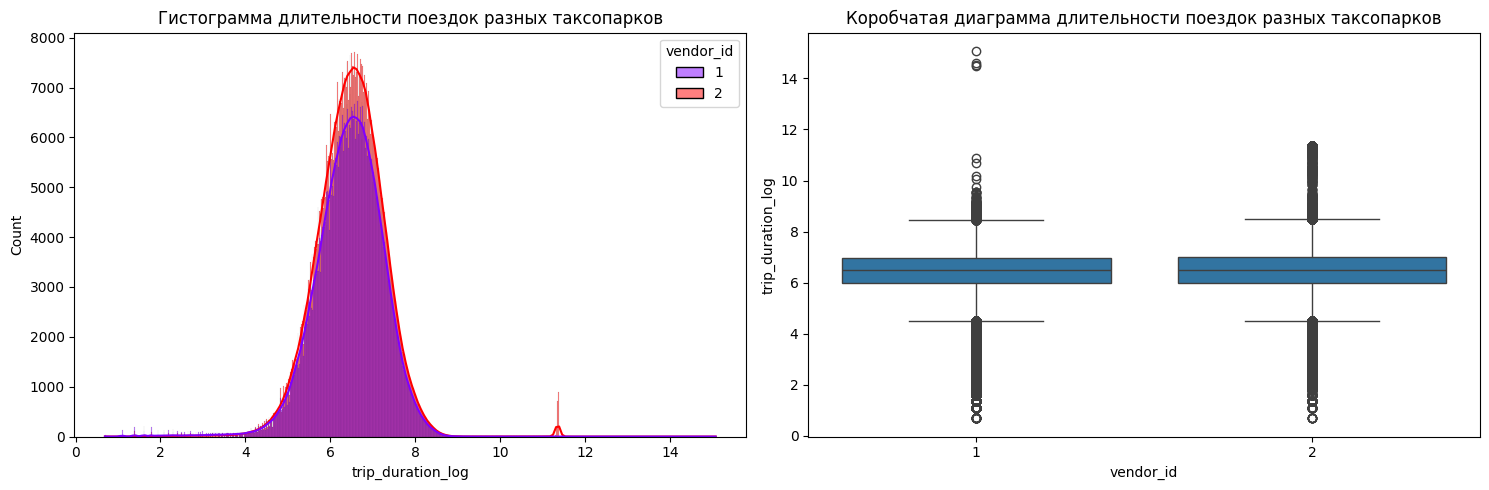

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Гистограмма длительности поездок разных таксопарков')
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    ax=ax[0],
    kde=True,
    hue='vendor_id',
    palette='rainbow'
    )

ax[1].set_title('Коробчатая диаграмма длительности поездок разных таксопарков')
sns.boxplot(
    ax=ax[1],
    data=taxi_data,
    y='trip_duration_log',
    x='vendor_id'
    )

fig.tight_layout()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

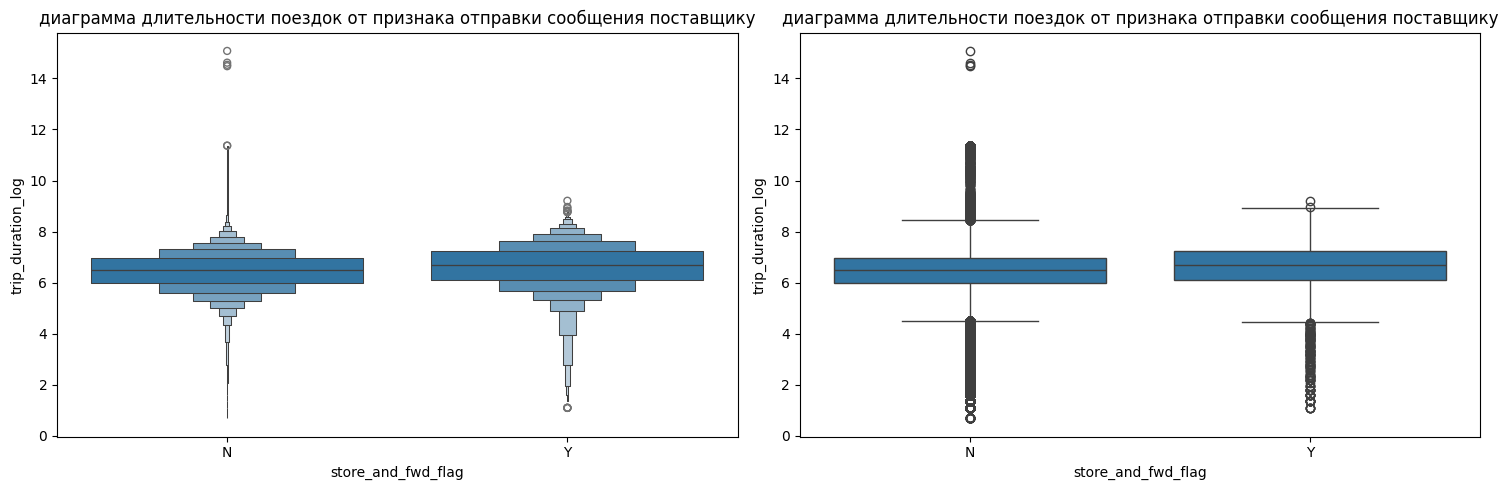

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('диаграмма длительности поездок от признака отправки сообщения поставщику')
sns.boxenplot(
    ax=ax[0],
    data=taxi_data,
    y='trip_duration_log',
    x='store_and_fwd_flag',
    )

ax[1].set_title('диаграмма длительности поездок от признака отправки сообщения поставщику')
sns.boxplot(
    ax=ax[1],
    data=taxi_data,
    y='trip_duration_log',
    x='store_and_fwd_flag'
    )

fig.tight_layout()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [ ]:
print(taxi_data.columns)

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'trip_duration_log'],
      dtype='object')


In [ ]:
# Преобразование столбца 'pickup_datetime' в datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])

# Извлечение часа из 'pickup_datetime'
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


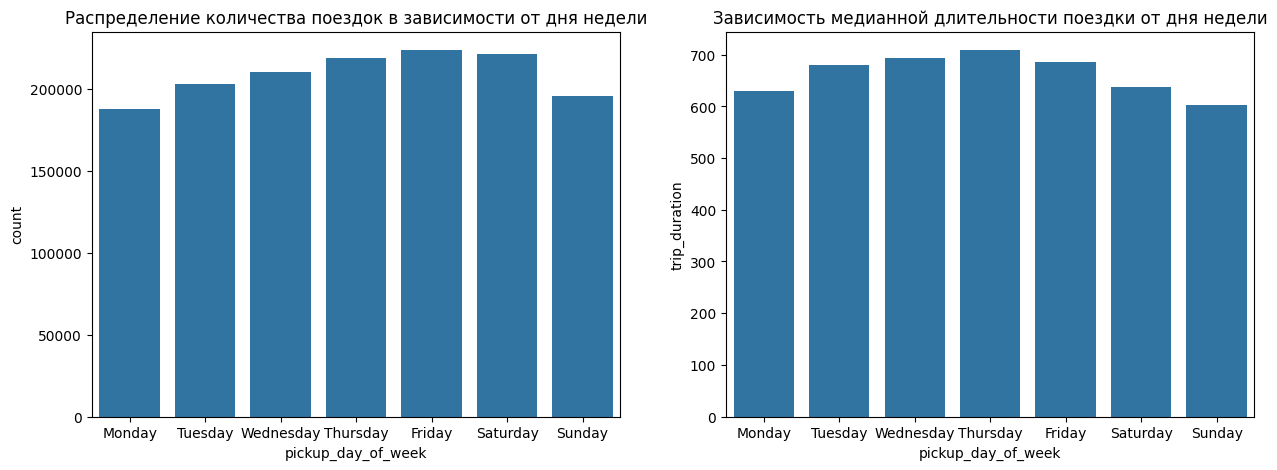

In [ ]:
taxi_data['pickup_datetime']=pd.to_datetime(taxi_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.day_name()

median_trip_2 = taxi_data.groupby(by='pickup_day_of_week')['trip_duration'].median().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Распределение количества поездок в зависимости от дня недели')
sns.countplot(
    ax=ax[0],
    data=taxi_data,
    x='pickup_day_of_week',
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
    )

ax[1].set_title('Зависимость медианной длительности поездки от дня недели')
sns.barplot(
    ax=ax[1],
    data=median_trip_2,
    y='trip_duration',
    x='pickup_day_of_week',
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
    );

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

''

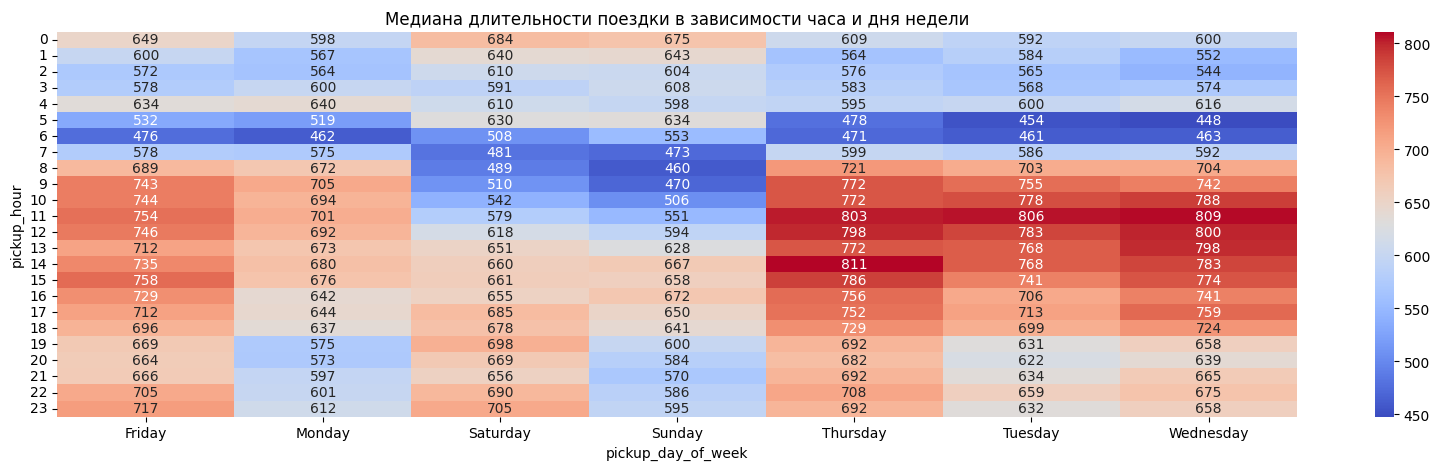

In [ ]:
pivot_df = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median',
)

fig, ax = plt.subplots(figsize=(20,5))

ax.set_title('Медиана длительности поездки в зависимости часа и дня недели')
plt.xticks()
sns.heatmap(
    data=pivot_df,
     annot=True,
      fmt='.0f',
       ax=ax,
        cmap='coolwarm'
        )
;

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


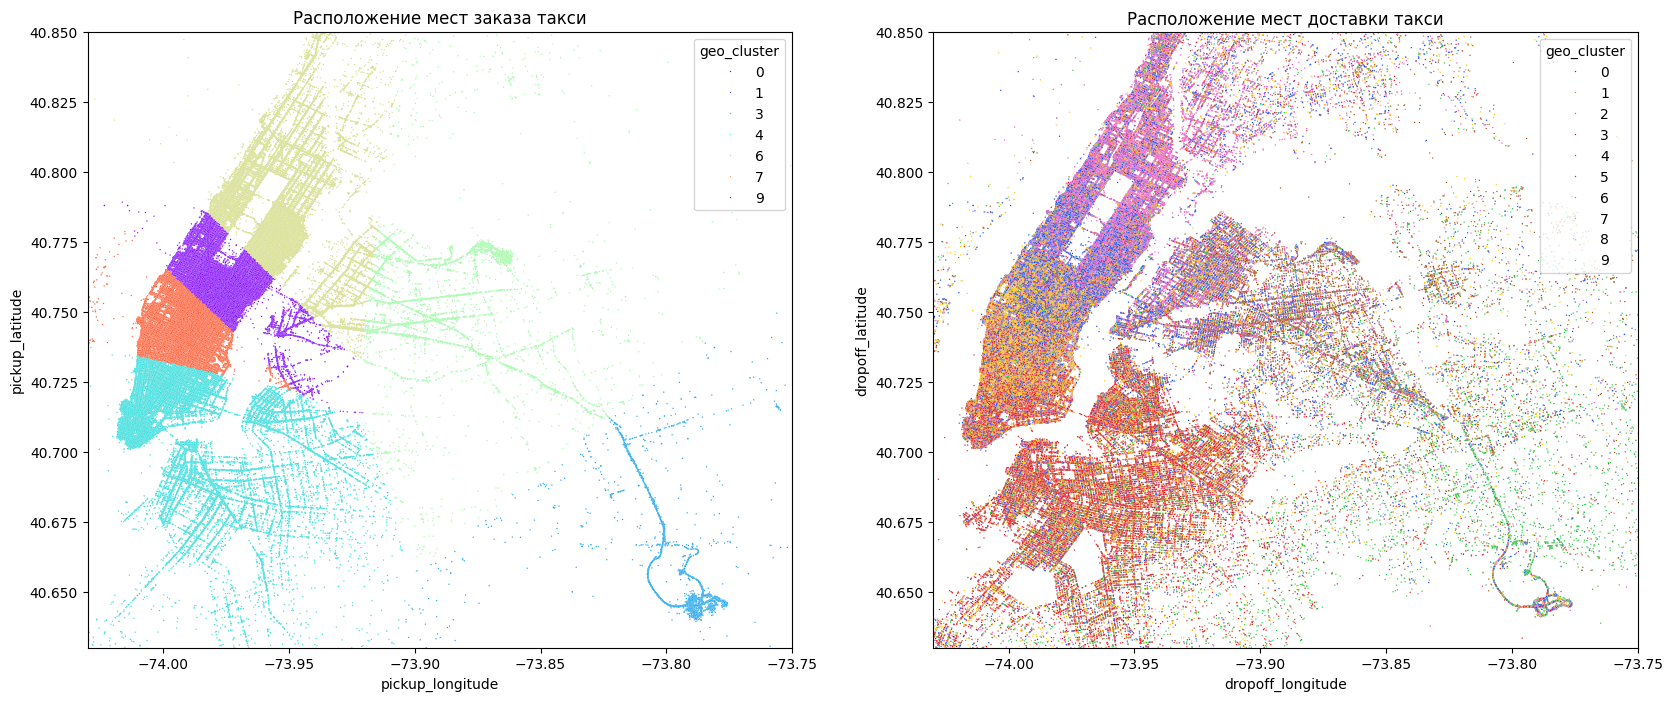

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

# Загрузка данных о поездках, если они еще не загружены
taxi_data = pd.read_csv('/content/drive/MyDrive/temp_df.csv', index_col=0)

# Если необходимо, создайте столбец 'geo_cluster'
if 'geo_cluster' not in taxi_data.columns:
    # Пример кластеризации на основе долготы и широты
    kmeans = KMeans(n_clusters=10, random_state=0).fit(taxi_data[['pickup_longitude', 'pickup_latitude']])
    taxi_data['geo_cluster'] = kmeans.labels_

# Определение границ города Нью-Йорк
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Создание фигуры с двумя подграфиками
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Подграфик для расположения мест заказа такси
ax[0].set_title('Расположение мест заказа такси')
ax[0].set_ylim(city_lat_border)
ax[0].set_xlim(city_long_border)
sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',  # Проверьте правильность указания hue
    s=1,
    ax=ax[0],
    palette='rainbow'
)

# Подграфик для расположения мест доставки такси
ax[1].set_title('Расположение мест доставки такси')
ax[1].set_ylim(city_lat_border)
ax[1].set_xlim(city_long_border)
sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',  # Проверьте правильность указания hue
    s=1,
    ax=ax[1],
    palette='bright'
)

# Отображение графиков
plt.show()


### Save point 2

In [ ]:
#Создадим точку восстановления, чтобы можно было вернуться в любой момент
taxi_data.to_csv('/content/drive/MyDrive/temp_df_2.csv')

taxi_data = pd.read_csv('/content/drive/MyDrive/temp_df_2.csv', index_col=0)
#Проверим, что датасет тот самый
print(taxi_data.shape)

(1458644, 12)


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:

# Проверка наличия столбцов и удаление
columns_to_drop = ['pickup_day_of_week', 'avg_speed']
existing_columns_to_drop = [col for col in columns_to_drop if col in taxi_data.columns]
taxi_data = taxi_data.drop(existing_columns_to_drop, axis=1)


In [ ]:
taxi_data = taxi_data.drop(['pickup_day_of_week', 'avg_speed'], axis=1, errors='ignore')

In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458644, 12)
Columns: Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'trip_duration_log', 'geo_cluster'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_log,geo_cluster
id,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,0
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,8
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,0
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,3
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,6


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [ ]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1, errors='ignore')
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458644, 11)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1, errors='ignore')
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458644, 10)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [ ]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

In [ ]:
print(f'среднее по закодированному столбцу vendor_id {train_data.vendor_id.mean():.2f}')
print(f'среднее по закодированному столбцу store_and_fwd_flag {train_data.store_and_fwd_flag.mean():.3f}')

среднее по закодированному столбцу vendor_id 0.53
среднее по закодированному столбцу store_and_fwd_flag 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице train_data с помощью OneHotEndoder() из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [ ]:
#здесь была нейронка

# Ваши исходные данные
categorical_columns = ['day_of_week', 'geo_cluster', 'events']

# Создаем экземпляр OneHotEncoder
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')

# Фильтруем существующие столбцы
existing_categorical_columns = [col for col in categorical_columns if col in train_data.columns]

# Проверяем, есть ли хотя бы один существующий категориальный столбец
if existing_categorical_columns:
    onehot = one_hot_encoder.fit_transform(train_data[existing_categorical_columns]).toarray()

    # Получаем новые сгенерированные имена колонок для one-hot кодирования
    column_names = one_hot_encoder.get_feature_names_out(existing_categorical_columns)

    # Создаем DataFrame из one-hot закодированных данных
    onehot = pd.DataFrame(onehot, columns=column_names)
    print(f'{onehot.shape[1]} бинарных столбцов у нас получилось сгенерировать')
else:
    print("Нет существующих категориальных столбцов для кодирования.")

9 бинарных столбцов у нас получилось сгенерировать


In [ ]:
categorical_columns = ['day_of_week', 'geo_cluster', 'events']
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')

onehot = one_hot_encoder.fit_transform(train_data[categorical_columns]).toarray()
column_names = one_hot_encoder.get_feature_names_out(categorical_columns)
onehot = pd.DataFrame(onehot, columns=column_names)
print(f'{onehot.shape[1]} бинарных столбцов у нас получилось сгенерировать')

KeyError: "['day_of_week', 'events'] not in index"

Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(categorical_columns, axis=1), onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

KeyError: "['day_of_week', 'events'] not found in axis"

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
X_new = SelectKBest(k=25, score_func=f_regression).fit(X_train, y_train_log)
best_features = X_new.get_feature_names_out()
print(list(best_features))

X_train = X_train[best_features]
X_valid = X_valid[best_features]

ValueError: k should be <= n_features = 8; got 25. Use k='all' to return all features.

In [ ]:
#Укажите признаки, которые вошли в список отобранных
question_list = [
    'vendor_id', 'passenger_count',
     'number_of_steps', 'temperature',
      'events_None', 'visibility',
       'wind speed']
answer_list = []

for i in list(best_features):
  if i in question_list:
    answer_list.append(i)

print(answer_list)

NameError: name 'best_features' is not defined

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print(f'среднее арифметическое для первого предиктора {round(X_valid_scaled.mean(), 2)}')

среднее арифметическое для первого предиктора 0.48


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train_scaled, y_train_log)
y_train_log_pred = lin_reg.predict(X_train_scaled)
y_valid_log_pred = lin_reg.predict(X_valid_scaled)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.2f}')

Train RMSLE 0.78
Valid RMSLE 0.78


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.fit_transform(X_valid_scaled)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = lin_reg.predict(X_train_scaled_poly)
y_valid_log_pred = lin_reg.predict(X_valid_scaled_poly)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.2f}')

Train RMSLE 0.76
Valid RMSLE 0.77


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = ridge.predict(X_train_scaled_poly)
y_valid_log_pred = ridge.predict(X_valid_scaled_poly)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.2f}')

Train RMSLE 0.77
Valid RMSLE 0.77


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
tree_reg = tree.DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_log)
y_train_log_pred = tree_reg.predict(X_train_scaled)
y_valid_log_pred = tree_reg.predict(X_valid_scaled)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.3f}')

Train RMSLE 0.01
Valid RMSLE 0.645


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


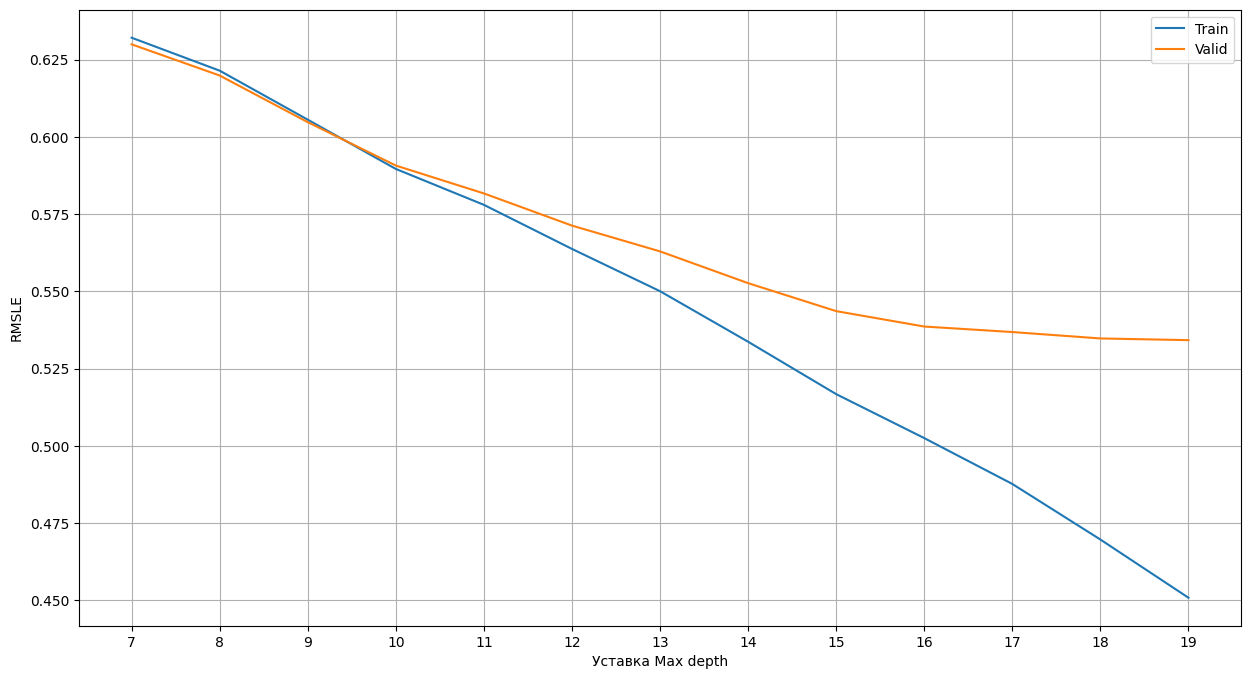

In [ ]:
max_depths = range(7, 20)
train_scores = []
valid_scores = []
for i in max_depths:
    dt = tree.DecisionTreeRegressor(max_depth=i)
    dt.fit(X_train_scaled, y_train_log)
    y_train_log_pred = dt.predict(X_train_scaled)
    y_valid_log_pred = dt.predict(X_valid_scaled)
    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)))
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x=max_depths, y=train_scores, label='Train')
sns.lineplot(x=max_depths, y=valid_scores, label='Valid')
ax.set_xlabel('Уставка Max depth')
ax.set_ylabel('RMSLE')
ax.set_xticks(max_depths)
ax.grid()

In [ ]:
#По графику минимальная RMSLE где-то при max_depth от 10 до 12
rmsle_per_max_deprth = pd.DataFrame(
    {'max_depth': max_depths,
     'rmsle_valid': valid_scores
    })
rmsle_per_max_deprth[rmsle_per_max_deprth['rmsle_valid'] < 0.4304]

,max_depth,rmsle_valid


In [ ]:
tree_reg = tree.DecisionTreeRegressor(max_depth=11)
tree_reg.fit(X_train_scaled, y_train_log)
y_train_log_pred = tree_reg.predict(X_train_scaled)
y_valid_log_pred = tree_reg.predict(X_valid_scaled)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.3f}')

Train RMSLE 0.58
Valid RMSLE 0.582


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train_log)
y_train_log_pred = rf.predict(X_train_scaled)
y_valid_log_pred = rf.predict(X_valid_scaled)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.3f}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   14.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s


Train RMSLE 0.55
Valid RMSLE 0.557


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    8.5s finished


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True,
)

gb.fit(X_train_scaled, y_train_log)
y_train_log_pred = gb.predict(X_train_scaled)
y_valid_log_pred = gb.predict(X_valid_scaled)

RMSLE_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
RMSLE_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print(f'Train RMSLE {RMSLE_train:.2f}')
print(f'Valid RMSLE {RMSLE_valid:.3f}')

      Iter       Train Loss   Remaining Time 
         1           0.4927            7.84m
         2           0.4559            7.04m
         3           0.4284            6.88m
         4           0.3834            7.16m
         5           0.3688            6.91m
         6           0.3640            6.74m
         7           0.3351            6.89m
         8           0.3096            6.74m
         9           0.2933            6.60m
        10           0.2861            6.64m
        20           0.2534            5.84m
        30           0.2437            5.14m
        40           0.2355            4.39m
        50           0.2309            3.66m
        60           0.2287            2.92m
        70           0.2253            2.20m
        80           0.2230            1.47m
        90           0.2214           44.02s
       100           0.2190            0.00s
Train RMSLE 0.47
Valid RMSLE 0.476


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


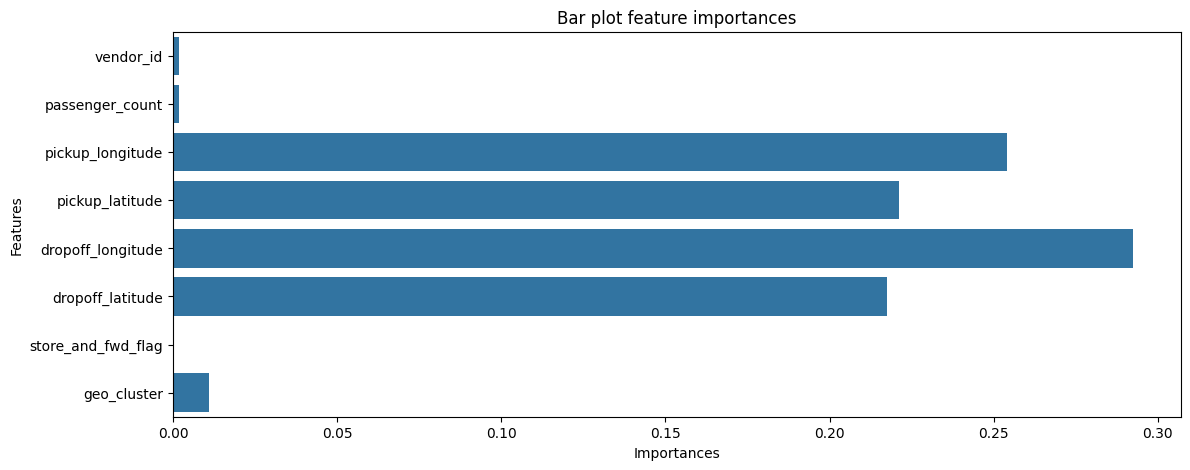

In [ ]:

feature = X.columns
feature_importances = gb.feature_importances_

fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(y=feature, x=feature_importances, orient='h', ax=ax)
ax.set_title('Bar plot feature importances')
ax.set_ylabel('Features')
ax.set_xlabel('Importances')

plt.show()


### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(gb.predict(X_valid_scaled)) - 1
Valid_MAE = metrics.median_absolute_error(y_valid_pred, y_valid)/60
print(f'Значение метрики MAE {Valid_MAE:.1f} минут')

Значение метрики MAE 2.5 минут


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Project5_test_data.zip")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/Project5_osrm_data_test.zip")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

def add_holiday_features(df, holiday_df):
    holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date
    df = df.merge(holiday_data, how='left', left_on='pickup_date', right_on='date')
    df['pickup_holiday'] = df['holiday'].fillna(0)
    df['pickup_holiday'] = df['pickup_holiday'].apply(lambda x: 0 if x == 0 else 1)
    df = df.drop(['day', 'date', 'holiday'], axis=1)
    return df


def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_manhattan_distance(lat1, lng1, lat2, lng2):
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    d = a + b
    return d

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

def add_distance_features(df):
    lat1, lat2 = df['pickup_latitude'].values, df['dropoff_latitude'].values
    lng1, lng2 = df['pickup_longitude'].values, df['dropoff_longitude'].values
    df['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    df['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return df

def add_weather_features(df, weather_df):
    weather_data['time'] = pd.to_datetime(weather_data['time'])
    weather_data['date'] = weather_data['time'].dt.date
    weather_data['hour'] = weather_data['time'].dt.hour

    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]

    df = df.merge(
        weather_data[weather_columns],
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'],
        how='left'
    )
    df = df.drop(['date', 'hour'], axis=1)
    return df

def add_cluster_features(df, cluster_model):
    df['geo_cluster'] = cluster_model.predict(df[['pickup_latitude', 'pickup_longitude',
                                                  'dropoff_latitude','dropoff_longitude']].values)
    return df

def add_osrm_features(df, osrm_df):
    osrm_features = [
        'id', 'total_distance',
        'total_travel_time', 'number_of_steps'
    ]
    df = df.merge(
        osrm_df[osrm_features],
        on='id',
        how='left'
    )
    return df

def clear_null_data(df):
    weather_columns = [
        'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]
    osrm_columns = [
        'total_distance',
        'total_travel_time',
        'number_of_steps'
    ]
    for col in weather_columns:
        if col == 'events':
            df['events'] = df['events'].fillna('None')
        else:
            df[col] = df[col].fillna(
                df.groupby('pickup_date')[col].transform('median')
            )
    for col in osrm_columns:
        df[col] = df[col].fillna(df[col].median())
    return df

In [ ]:
def add_cluster_features(data, kmeans):
    # Используем только нужные признаки для кластеризации
    features_for_clustering = ['pickup_longitude', 'pickup_latitude']

    if not all(feature in data.columns for feature in features_for_clustering):
        raise ValueError(f"Data must contain the following features: {features_for_clustering}")

    # Проверка количества признаков
    if data[features_for_clustering].shape[1] != kmeans.n_features_in_:
        raise ValueError(f"Data has {data[features_for_clustering].shape[1]} features, but KMeans is expecting {kmeans.n_features_in_} features as input.")

    # Применение модели KMeans к данным
    data['geo_cluster'] = kmeans.predict(data[features_for_clustering])
    return data

test_data = add_cluster_features(test_data, kmeans)



Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
model = gb
y_test_predict = np.exp(model.predict(X_test_scaled)) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/submission_gb.csv', index=False)

NameError: name 'X_test_scaled' is not defined

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=features)

NameError: name 'features' is not defined

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

NameError: name 'dtrain' is not defined

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

NameError: name 'dtest' is not defined

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


ValueError: tree must be Booster, XGBModel or dict instance

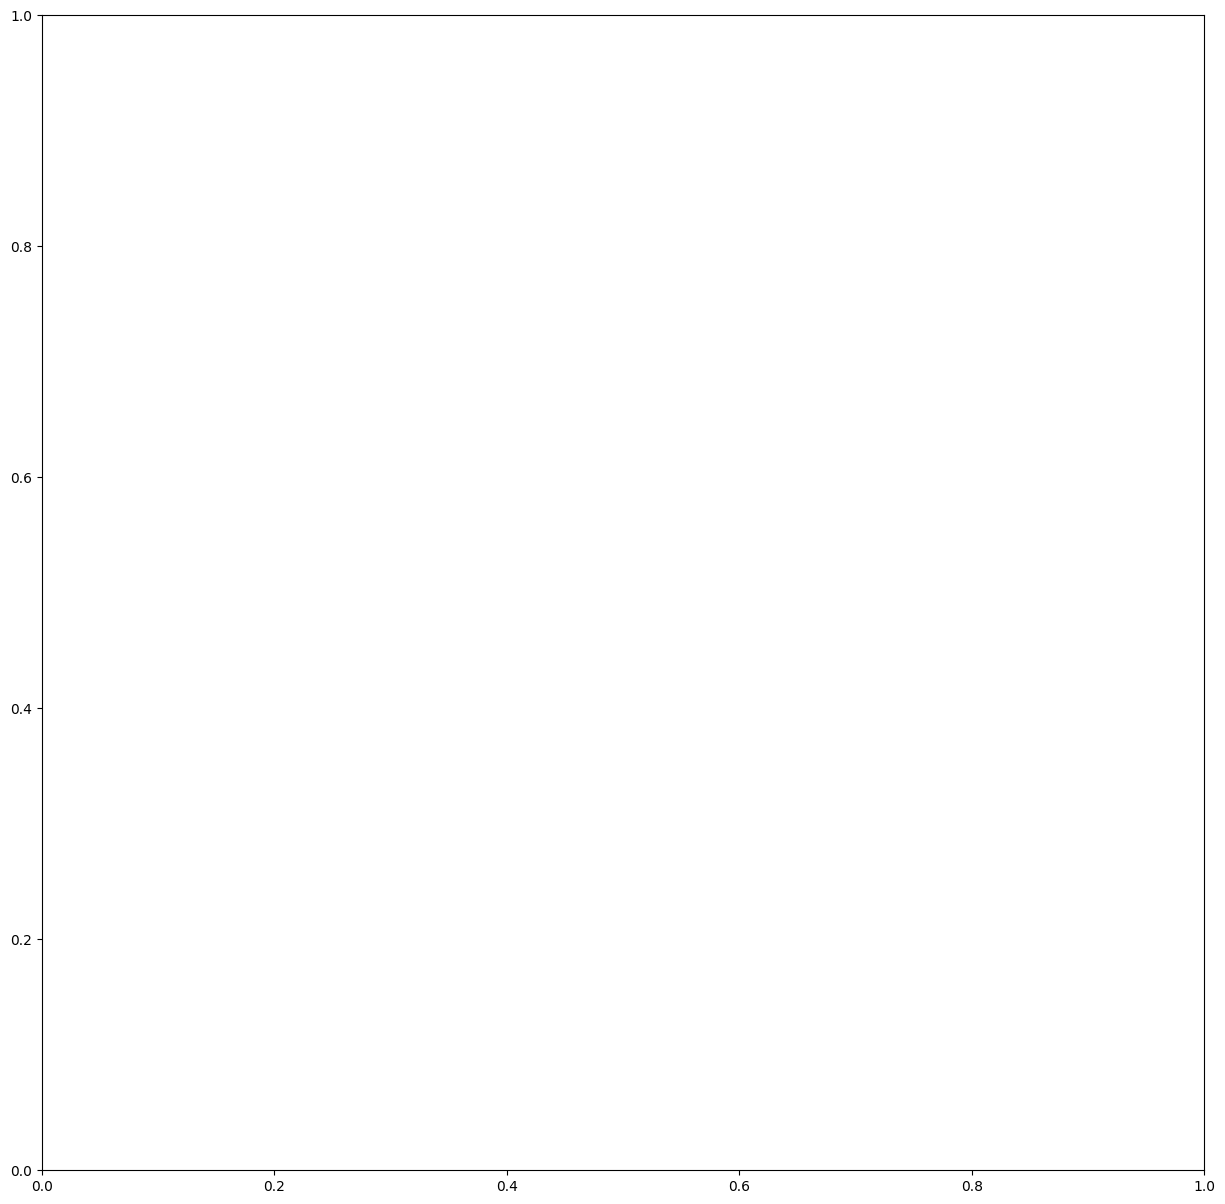

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)